***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet\Training_and_Analysis\1_EMNIST
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Import Dataset : EMNIST

In [4]:
dataset = datasets.E_MNIST(version = 'ALL') # importing Dataset
num_fine  = 47

EMNIST dataset: Training have 112,800 samples and testing have 18,800 samples


# Parameters

In [5]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [6]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [7]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [8]:
coarse_to_fine_array = np.zeros(shape=[number_of_classes_c,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_train_fine'])):
    coarse_to_fine_array[c_id[x]][f_id[x]] = 1

Matrix_coarse_to_fine_OneHot = tf.constant(coarse_to_fine_array, dtype=tf.float32)

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_f, y_pred_c, y_pred_f, LW_C, LW_F,
               number_of_classes_f, C_Weight=0.2):
    
    con_f = consistency_check(y_pred_c,y_pred_f,Matrix_coarse_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_f = get_consistency(y_true_c,y_pred_f,Matrix_coarse_to_fine_OneHot)
    
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_c_dims = 16

    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshape= keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshape)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_f],
                        outputs= [pred_c, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_f, pred_c, pred_f,
                              lossweight['coarse_lw'], lossweight['fine_lw'], number_of_classes_f))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

## log directory

In [12]:
directory = sysenv.log_dir('1_EMNIST/HD_CapsNet/W_C_loss')

FOLDER CREATED =  ../../logs/1_EMNIST/HD_CapsNet/W_C_loss


In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_5 (TFOpLambda  (None, 47)          0           ['prediction_fine[0][0]']        
 )                                                                                                
                                                                                                  
 tf.math.subtract_6 (TFOpLambda  (None, 47)          0           ['prediction_fine[0][0]']        
 )                                                                                                
                                                                                                  
 tf.compat.v1.gather_1 (TFOpLam  (None, 47)          0           ['tf.cast[0][0]']                
 bda)                                                                                             
                                                                                                  
 tf.math.d

 )                                                                'tf.math.square[0][0]']         
                                                                                                  
 tf.math.multiply_5 (TFOpLambda  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 )                                                                'tf.math.square_1[0][0]']       
                                                                                                  
 tf.math.reduce_sum_4 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)                                                                                              
                                                                                                  
 tf.math.multiply_2 (TFOpLambda  (None,)             0           ['tf.math.abs_1[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_2level(dataset['x_train'],
                                                 dataset['y_train_coarse'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                    steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                    epochs = train_params["n_epochs"],
                    validation_data = ([dataset['x_test'],
                                        dataset['y_test_coarse'],dataset['y_test_fine']],
                                       [dataset['y_test_coarse'],dataset['y_test_fine']]),
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.1041 - prediction_coarse_accuracy: 0.8843 - prediction_fine_accuracy: 0.2790
  • Coarse Accuracy = 88.43% | Val_Accuracy = 91.17% | LossWeight = 0.79 
  • Fine   Accuracy = 27.91% | Val_Accuracy = 57.80% | LossWeight = 0.21 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.57798, saving model to ../../logs/1_EMNIST/HD_CapsNet/W_C_loss\epoch-best.h5
1762/1762 [==============================] - 99s 53ms/step - loss: 0.1041 - prediction_coarse_accuracy: 0.8843 - prediction_fine_accuracy: 0.2791 - val_loss: 0.0658 - val_prediction_coarse_accuracy: 0.9117 - val_prediction_fine_accuracy: 0.5780 - lr: 0.0010
Epoch 2/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0596 - prediction_coarse_accuracy: 0.9199 - prediction_fine_accuracy: 0.7417
  • Coarse Accuracy = 91.99% | Val_Accuracy = 92.95% | LossWeight = 0.88 
  • Fine   Accuracy = 74.17% | Val_Accuracy = 82.29% | LossWeight = 0.12 

E

Epoch 12/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0507 - prediction_coarse_accuracy: 0.9448 - prediction_fine_accuracy: 0.8719
  • Coarse Accuracy = 94.48% | Val_Accuracy = 94.42% | LossWeight = 0.91 
  • Fine   Accuracy = 87.19% | Val_Accuracy = 88.84% | LossWeight = 0.09 

Epoch 12: val_prediction_fine_accuracy improved from 0.88394 to 0.88835, saving model to ../../logs/1_EMNIST/HD_CapsNet/W_C_loss\epoch-best.h5
1762/1762 [==============================] - 91s 52ms/step - loss: 0.0507 - prediction_coarse_accuracy: 0.9448 - prediction_fine_accuracy: 0.8719 - val_loss: 0.0335 - val_prediction_coarse_accuracy: 0.9442 - val_prediction_fine_accuracy: 0.8884 - lr: 9.0250e-04
Epoch 13/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0505 - prediction_coarse_accuracy: 0.9463 - prediction_fine_accuracy: 0.8739
  • Coarse Accuracy = 94.63% | Val_Accuracy = 94.51% | LossWeight = 0.91 
  • Fine   Accuracy = 87.39% | Val_Accuracy = 89.02% | LossWeight 

Epoch 24/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0451 - prediction_coarse_accuracy: 0.9565 - prediction_fine_accuracy: 0.8912
  • Coarse Accuracy = 95.65% | Val_Accuracy = 94.66% | LossWeight = 0.90 
  • Fine   Accuracy = 89.12% | Val_Accuracy = 89.15% | LossWeight = 0.10 

Epoch 24: val_prediction_fine_accuracy did not improve from 0.89431
1762/1762 [==============================] - 92s 52ms/step - loss: 0.0451 - prediction_coarse_accuracy: 0.9565 - prediction_fine_accuracy: 0.8912 - val_loss: 0.0345 - val_prediction_coarse_accuracy: 0.9466 - val_prediction_fine_accuracy: 0.8915 - lr: 4.8767e-04
Epoch 25/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0446 - prediction_coarse_accuracy: 0.9563 - prediction_fine_accuracy: 0.8923
  • Coarse Accuracy = 95.63% | Val_Accuracy = 94.56% | LossWeight = 0.91 
  • Fine   Accuracy = 89.23% | Val_Accuracy = 89.38% | LossWeight = 0.09 

Epoch 25: val_prediction_fine_accuracy did not improve from 0.8943

1761/1762 [============================>.] - ETA: 0s - loss: 0.0404 - prediction_coarse_accuracy: 0.9649 - prediction_fine_accuracy: 0.9018
  • Coarse Accuracy = 96.49% | Val_Accuracy = 94.57% | LossWeight = 0.89 
  • Fine   Accuracy = 90.18% | Val_Accuracy = 89.34% | LossWeight = 0.11 

Epoch 36: val_prediction_fine_accuracy did not improve from 0.89580
1762/1762 [==============================] - 91s 52ms/step - loss: 0.0404 - prediction_coarse_accuracy: 0.9649 - prediction_fine_accuracy: 0.9018 - val_loss: 0.0363 - val_prediction_coarse_accuracy: 0.9457 - val_prediction_fine_accuracy: 0.8934 - lr: 2.6352e-04
Epoch 37/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0399 - prediction_coarse_accuracy: 0.9655 - prediction_fine_accuracy: 0.9029
  • Coarse Accuracy = 96.55% | Val_Accuracy = 94.68% | LossWeight = 0.89 
  • Fine   Accuracy = 90.29% | Val_Accuracy = 89.41% | LossWeight = 0.11 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.89580
1762/1762 [

1762/1762 [==============================] - 90s 51ms/step - loss: 0.0369 - prediction_coarse_accuracy: 0.9700 - prediction_fine_accuracy: 0.9097 - val_loss: 0.0378 - val_prediction_coarse_accuracy: 0.9439 - val_prediction_fine_accuracy: 0.8933 - lr: 1.4240e-04
Epoch 49/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0372 - prediction_coarse_accuracy: 0.9706 - prediction_fine_accuracy: 0.9097
  • Coarse Accuracy = 97.06% | Val_Accuracy = 94.49% | LossWeight = 0.88 
  • Fine   Accuracy = 90.97% | Val_Accuracy = 89.38% | LossWeight = 0.12 

Epoch 49: val_prediction_fine_accuracy did not improve from 0.89580
1762/1762 [==============================] - 94s 53ms/step - loss: 0.0372 - prediction_coarse_accuracy: 0.9706 - prediction_fine_accuracy: 0.9097 - val_loss: 0.0377 - val_prediction_coarse_accuracy: 0.9449 - val_prediction_fine_accuracy: 0.8938 - lr: 1.3528e-04
Epoch 50/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0367 - prediction_coarse_accur

Epoch 61/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0352 - prediction_coarse_accuracy: 0.9745 - prediction_fine_accuracy: 0.9146
  • Coarse Accuracy = 97.45% | Val_Accuracy = 94.41% | LossWeight = 0.87 
  • Fine   Accuracy = 91.46% | Val_Accuracy = 89.31% | LossWeight = 0.13 

Epoch 61: val_prediction_fine_accuracy did not improve from 0.89590
1762/1762 [==============================] - 92s 52ms/step - loss: 0.0352 - prediction_coarse_accuracy: 0.9745 - prediction_fine_accuracy: 0.9146 - val_loss: 0.0389 - val_prediction_coarse_accuracy: 0.9441 - val_prediction_fine_accuracy: 0.8931 - lr: 7.3098e-05
Epoch 62/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0348 - prediction_coarse_accuracy: 0.9743 - prediction_fine_accuracy: 0.9163
  • Coarse Accuracy = 97.43% | Val_Accuracy = 94.45% | LossWeight = 0.88 
  • Fine   Accuracy = 91.63% | Val_Accuracy = 89.44% | LossWeight = 0.12 

Epoch 62: val_prediction_fine_accuracy did not improve from 0.8959

1762/1762 [==============================] - 91s 52ms/step - loss: 0.0336 - prediction_coarse_accuracy: 0.9764 - prediction_fine_accuracy: 0.9177 - val_loss: 0.0395 - val_prediction_coarse_accuracy: 0.9424 - val_prediction_fine_accuracy: 0.8950 - lr: 3.9499e-05
Epoch 74/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0339 - prediction_coarse_accuracy: 0.9760 - prediction_fine_accuracy: 0.9172
  • Coarse Accuracy = 97.60% | Val_Accuracy = 94.34% | LossWeight = 0.87 
  • Fine   Accuracy = 91.72% | Val_Accuracy = 89.56% | LossWeight = 0.13 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.89590
1762/1762 [==============================] - 88s 50ms/step - loss: 0.0339 - prediction_coarse_accuracy: 0.9760 - prediction_fine_accuracy: 0.9172 - val_loss: 0.0393 - val_prediction_coarse_accuracy: 0.9434 - val_prediction_fine_accuracy: 0.8956 - lr: 3.7524e-05
Epoch 75/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0335 - prediction_coarse_accur

1762/1762 [==============================] - ETA: 0s - loss: 0.0334 - prediction_coarse_accuracy: 0.9774 - prediction_fine_accuracy: 0.9188
  • Coarse Accuracy = 97.74% | Val_Accuracy = 94.18% | LossWeight = 0.87 
  • Fine   Accuracy = 91.88% | Val_Accuracy = 89.48% | LossWeight = 0.13 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.89590
1762/1762 [==============================] - 130s 74ms/step - loss: 0.0334 - prediction_coarse_accuracy: 0.9774 - prediction_fine_accuracy: 0.9188 - val_loss: 0.0399 - val_prediction_coarse_accuracy: 0.9418 - val_prediction_fine_accuracy: 0.8948 - lr: 2.0277e-05
Epoch 87/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0330 - prediction_coarse_accuracy: 0.9777 - prediction_fine_accuracy: 0.9201
  • Coarse Accuracy = 97.77% | Val_Accuracy = 94.31% | LossWeight = 0.87 
  • Fine   Accuracy = 92.01% | Val_Accuracy = 89.49% | LossWeight = 0.13 

Epoch 87: val_prediction_fine_accuracy did not improve from 0.89590
1762/1762 

1762/1762 [==============================] - 131s 75ms/step - loss: 0.0328 - prediction_coarse_accuracy: 0.9781 - prediction_fine_accuracy: 0.9197 - val_loss: 0.0400 - val_prediction_coarse_accuracy: 0.9427 - val_prediction_fine_accuracy: 0.8941 - lr: 1.0957e-05
Epoch 99/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0327 - prediction_coarse_accuracy: 0.9778 - prediction_fine_accuracy: 0.9191
  • Coarse Accuracy = 97.78% | Val_Accuracy = 94.21% | LossWeight = 0.87 
  • Fine   Accuracy = 91.91% | Val_Accuracy = 89.39% | LossWeight = 0.13 

Epoch 99: val_prediction_fine_accuracy did not improve from 0.89590
1762/1762 [==============================] - 129s 73ms/step - loss: 0.0327 - prediction_coarse_accuracy: 0.9778 - prediction_fine_accuracy: 0.9191 - val_loss: 0.0399 - val_prediction_coarse_accuracy: 0.9421 - val_prediction_fine_accuracy: 0.8939 - lr: 1.0409e-05
Epoch 100/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0325 - prediction_coarse_ac

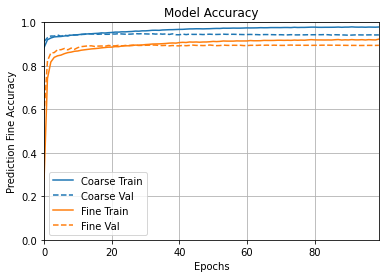

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

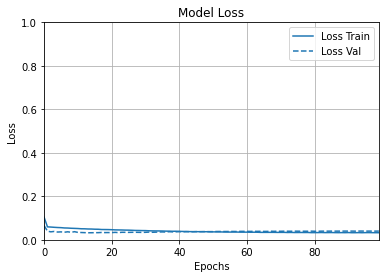

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : model_params['loss_function'],
                          'prediction_coarse' : model_params['loss_function']},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

588/588 [==============================] - 12s 19ms/step - loss: 0.0480 - prediction_coarse_loss: 0.0431 - prediction_fine_loss: 0.0802 - prediction_coarse_accuracy: 0.9423 - prediction_fine_accuracy: 0.8944
1. loss ==> 0.04801484942436218
2. prediction_coarse_loss ==> 0.04306064918637276
3. prediction_fine_loss ==> 0.08019882440567017
4. prediction_coarse_accuracy ==> 0.9422872066497803
5. prediction_fine_accuracy ==> 0.8944149017333984
588/588 [==============================] - 9s 14ms/step


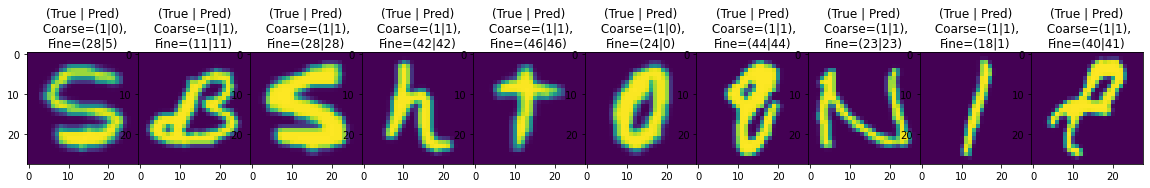

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 3425   575]
 [  510 14290]]

  • FINE LEVEL 
[[246   0   0 ...   0   0   0]
 [  0 241   1 ...   1   0   0]
 [  0   0 361 ...   1   0   0]
 ...
 [  1   0   0 ... 270   0   0]
 [  0   0   0 ...   0 373   1]
 [  0   0   0 ...   0   4 372]]

  • Classification Report 


  • COARSE LEVEL 


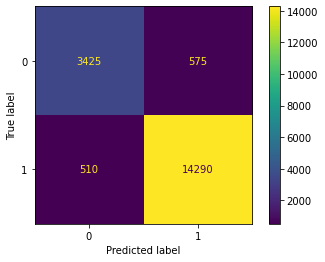

              precision    recall  f1-score   support

           0    0.87039   0.85625   0.86326      4000
           1    0.96132   0.96554   0.96342     14800

    accuracy                        0.94229     18800
   macro avg    0.91586   0.91090   0.91334     18800
weighted avg    0.94197   0.94229   0.94211     18800


  • FINE LEVEL 


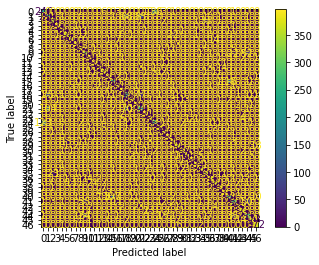

              precision    recall  f1-score   support

           0    0.64398   0.61500   0.62916       400
           1    0.57381   0.60250   0.58780       400
           2    0.92092   0.90250   0.91162       400
           3    0.99250   0.99250   0.99250       400
           4    0.95250   0.95250   0.95250       400
           5    0.95876   0.93000   0.94416       400
           6    0.94962   0.94250   0.94605       400
           7    0.97525   0.98500   0.98010       400
           8    0.95262   0.95500   0.95381       400
           9    0.74825   0.80250   0.77443       400
          10    0.96341   0.98750   0.97531       400
          11    0.97297   0.99000   0.98141       400
          12    0.96977   0.96250   0.96612       400
          13    0.93516   0.93750   0.93633       400
          14    0.97037   0.98250   0.97640       400
          15    0.70951   0.69000   0.69962       400
          16    0.92978   0.96000   0.94465       400
          17    0.96594   0

In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9188741134751772 
Hierarchical Recall = 0.9218617021276596 
Hierarchical F1-Score = 0.9200691489361702 
Consistency =  0.9886170212765958 
Exact Match =  0.8878723404255319
